In [1]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_excel('data/data.xlsx')

## Data cleaning and feature selection

In [4]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [5]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [8]:
data_macro = data.copy()

---

In [9]:
# Creating target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    2646
1     543
Name: cmltv_90_bad, dtype: int64


In [10]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [11]:
data_macro.isna().sum()

client_id                                                        0
loan_currency                                                    0
loan_amount                                                      0
date_of_disbursement                                             0
date_of_closure_based_on_contract                                0
duration_at_disbursement_months                                  0
interest_rate                                                    0
max_dpd_3_year                                                   0
cumulative_days_of_late_payments_throughout_loan_repayments      0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
type_of_product                                                  0
status_of_loan                                                   0
location                                                         0
emirates                                                         0
gender                                                        

In [12]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [14]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN


In [13]:
data_macro[['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
0,AED,0.0549,60.0
1,AED,0.0300,229.0
2,AED,0.0457,51.0
3,AED,0.0686,44.0
4,AED,0.0457,436.0
...,...,...,...
3184,AED,0.0750,122.0
3185,AED,0.0600,82.0
3186,AED,0.1150,128.0
3187,AED,0.0550,23.0


In [15]:
data_na = data_macro.dropna(subset=cat_feats+num_feats)

---

In [16]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_na[(data_na['status_of_loan'] == 'Active') & (data_na[target] == 1) | (data_na['status_of_loan'] != 'Active')]

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [18]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    train[col+'_mean_encoded'] = train[col].copy()
    test[col+'_mean_encoded'] = test[col].copy()
    
    for i in train[col+'_mean_encoded'].unique():
        train[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        
        test[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

In [19]:
# Removing classes that are in test set but not in train set #
for i in test.index :
    for col in cat_feats :
        if type(test[col+'_mean_encoded'][i]) == str:
            test.drop(i,inplace=True)
            break

In [20]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

---

In [21]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns :
            print(i)

All variables are found in feature lists


In [22]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

True

# Modeling
---

In [30]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},

    max_encoding_ohe=70,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False,
    
    session_id=15,
)

,Description,Value
0,Session id,15
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(2679, 41)"
4,Transformed data shape,"(2679, 20)"
5,Transformed train set shape,"(2152, 20)"
6,Transformed test set shape,"(527, 20)"
7,Ignore features,20
8,Numeric features,20
9,Rows with missing values,1.7%


In [31]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.01,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8515,0.8096,0.3678,0.7805,0.5000,0.4257,0.4674
1,0.8306,0.8425,0.2759,0.7059,0.3967,0.3195,0.3675
2,0.8558,0.8251,0.3837,0.7857,0.5156,0.4424,0.4818
3,0.8349,0.8442,0.2907,0.7143,0.4132,0.3364,0.3827
4,0.8419,0.8077,0.3448,0.7317,0.4688,0.3896,0.4278
Mean,0.8429,0.8258,0.3326,0.7436,0.4589,0.3828,0.4254
Std,0.0096,0.0155,0.0424,0.0333,0.0468,0.0482,0.0450


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8197,0.7825,0.2095,0.6471,0.3165,0.2427,0.2944


{'0': {'precision': 0.8722358722358723,
       'recall': 0.8412322274881516,
       'f1-score': 0.8564535585042219,
       'support': 422},
 '1': {'precision': 0.44166666666666665,
       'recall': 0.5047619047619047,
       'f1-score': 0.4711111111111111,
       'support': 105},
 'accuracy': 0.7741935483870968,
 'macro avg': {'precision': 0.6569512694512695,
               'recall': 0.6729970661250282,
               'f1-score': 0.6637823348076665,
               'support': 527},
 'weighted avg': {'precision': 0.7864488388681937,
                  'recall': 0.7741935483870968,
                  'f1-score': 0.7796775490615716,
                  'support': 527},
 'threshold': 0.25,
 'TN': 355,
 'FP': 67,
 'FN': 52,
 'TP': 53,
 'AUC': 0.7825,
 'model NPL': 12.78,
 ' real NPL': 19.92,
 'approval rate': 77.23,
 'good correct': 84.12,
 'bad correct': 50.48}


In [33]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8197,0.7825,0.2095,0.6471,0.3165,0.2427,0.2944


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.597723,0.782476,224.0,198.0,14.0,91.0
1,0.15,0.683112,0.782476,284.0,138.0,29.0,76.0
2,0.20,0.741935,0.782476,325.0,97.0,39.0,66.0
3,0.25,0.774194,0.782476,355.0,67.0,52.0,53.0
4,0.30,0.791271,0.782476,381.0,41.0,69.0,36.0


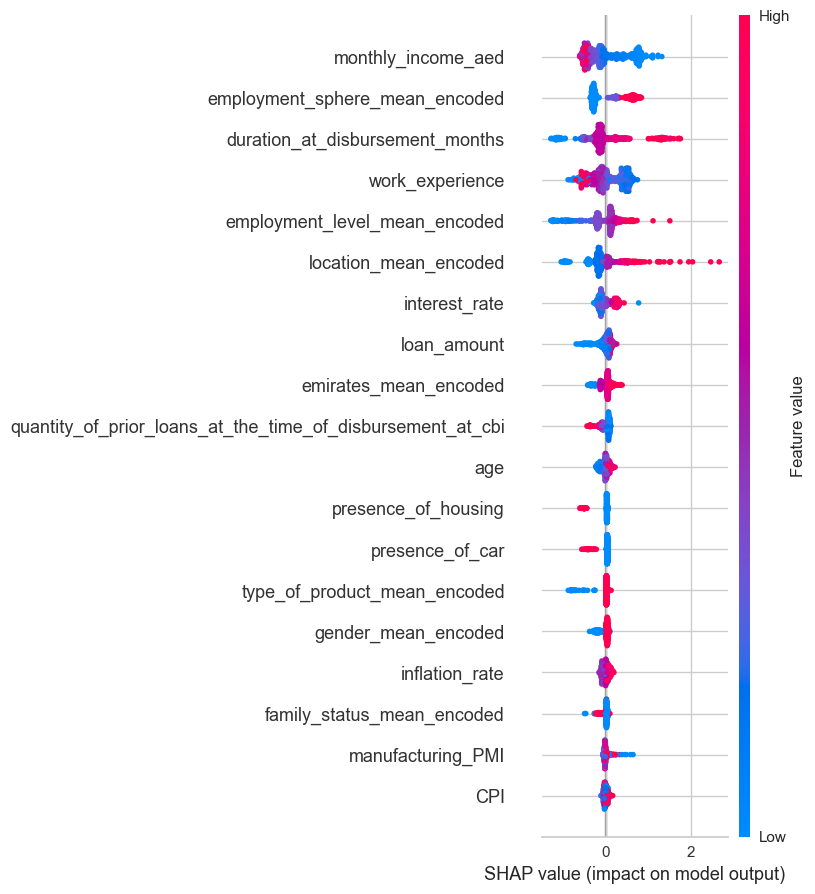

In [34]:
exp.interpret_model(trained_model_catboost)